## Cleanup Previo
En el respositorio del proyecto se encuentran dos pequeños scripts de Python, `download.py` y `rewrite.py`. Estos scripts fueron ejecutados para descargar el set de datos de la página provista, y juntar los resultados (varios archivos `.csv`) en un sólo archivo, a través de `pandas`. A partir de este último, se hace un filtrado de los resultados por ubicación de las propiedades, para quedarnos solo con las del Gran Buenos Aires. Este último DataFrame es el punto de partida de nuestro análisis exploratorio, y para no tener que correr la limpieza cada vez que se trabaja sobre él, se guarda en un csv nuevo.

In [1]:
import pandas as pd
import numpy as np
import mplleaflet
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point, Polygon
from math import sin,cos,sqrt,asin,pi
%matplotlib inline  

## Carga de datos
Cargo solo las columnas que nos pueden llegar a interesar. En particular, ignoro varias que tienen URL a imágenes y descripciones de las propiedades individuales. 

In [2]:
dtypes = {
    'country_name': str,
    'expenses': object,
    'id': str,
    'title': str,
    'state_name': str,
    'lat': float,
    'lon': float
}
cols = range(6) + range(8, 18) + [20, 21] + range(23, 27)
parse_dates = ['created_on']

df = pd.read_csv('data/data_gba_total.csv', dtype=dtypes, usecols=cols, parse_dates=parse_dates)


In [3]:
len(df)

2409471

In [4]:
df.head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
0,Argentina,2015-07-01,USD,1500.0,NaN,3430234.0,-34.574594,"-34.5745944268,-58.4192548517",-58.419255,sell,...,71000.0,1133763.5,71000.0,2448.275862,apartment,1.0,29.0,NaN,29.0,Departamento en Palermo
1,Argentina,2015-07-01,USD,1.0,NaN,3427455.0,-34.610611,"-34.6106110157,-58.4795902886",-58.479590,sell,...,96000.0,1532976.0,96000.0,2285.714286,apartment,2.0,42.0,NaN,47.0,SAN BLAS 2700 6º- A ESTRENAR
2,Argentina,2015-07-01,USD,1.0,NaN,3427455.0,-34.610611,"-34.6106110157,-58.4795902886",-58.479590,sell,...,86000.0,1373291.0,86000.0,2047.619048,apartment,2.0,42.0,NaN,47.0,SAN BLAS 2700 4º- A ESTRENAR
3,Argentina,2015-07-01,USD,NaN,NaN,3436134.0,-34.639086,"-34.639086,-58.369347",-58.369347,sell,...,165000.0,2634802.5,165000.0,2115.384615,apartment,1.0,78.0,NaN,86.0,DEPARTAMENTO EN VENTA
4,Argentina,2015-07-01,USD,NaN,NaN,3436134.0,-34.678121,"-34.6781214564,-58.3922113975",-58.392211,sell,...,85000.0,1357322.5,85000.0,1133.333333,house,NaN,75.0,NaN,65.0,Duplex en PH - Avellaneda - Excelente


In [5]:
df.columns

Index([u'country_name', u'created_on', u'currency', u'expenses', u'floor',
       u'geonames_id', u'lat', u'lat-lon', u'lon', u'operation', u'place_name',
       u'place_with_parent_names', u'price', u'price_aprox_local_currency',
       u'price_aprox_usd', u'price_per_m2', u'property_type', u'rooms',
       u'surface_covered_in_m2', u'surface_in_m2', u'surface_total_in_m2',
       u'title'],
      dtype='object')

Verifico que los precios sean lógicos (por lo menos positivos!)

In [6]:
df.sort_values('price_aprox_usd').head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
86890,Argentina,2016-08-30,NaN,NaN,NaN,6693229.0,-34.594147,"-34.5941468,-58.4424053",-58.442405,sell,...,0.0,0.0,0.0,NaN,apartment,NaN,38.0,NaN,38.0,Departamento de 1 ambiente en Venta en
696892,Argentina,2016-04-26,USD,NaN,NaN,NaN,NaN,NaN,NaN,sell,...,0.0,0.0,0.0,NaN,house,4.0,102.0,NaN,132.0,Triplex en Venta Haedo / Moron (A124 458)
583482,Argentina,2016-11-18,NaN,NaN,NaN,3832749.0,-34.933653,"-34.933653,-57.889302",-57.889302,sell,...,0.0,0.0,0.0,NaN,house,3.0,NaN,NaN,NaN,Casa de 2 dormitorios con parque en Villa Elvira
16739,Argentina,2015-12-29,NaN,NaN,NaN,3435874.0,NaN,NaN,NaN,sell,...,0.0,0.0,0.0,NaN,apartment,NaN,NaN,NaN,NaN,U$D 98.000 - Departamento en Venta - Alberdi ...
696864,Argentina,2016-06-14,USD,NaN,NaN,3429617.0,NaN,NaN,NaN,sell,...,0.0,0.0,0.0,NaN,apartment,3.0,84.0,NaN,NaN,Semipiso en Venta Ramos Mejia / La Matanza (A0...


In [7]:
df = df[df['price_aprox_usd'] > 0]

In [8]:
df.sort_values('price_aprox_usd').head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
549065,Argentina,2015-07-19,ARS,NaN,NaN,3436394.0,-34.828152,"-34.8281517,-58.3865471",-58.386547,sell,...,45701.0,48432.14,3032.98,3515.461538,apartment,1.0,13.0,NaN,14.0,Departamentos venta
3488,Argentina,2015-08-27,ARS,NaN,NaN,3436003.0,-34.625948,"-34.6259482,-58.4195408",-58.419541,sell,...,46405.0,49178.18,3079.70,1546.833333,apartment,1.0,30.0,NaN,30.0,Departamentos venta
10644,Argentina,2015-08-27,ARS,NaN,NaN,3436003.0,-34.625948,"-34.6259482,-58.4195408",-58.419541,sell,...,46405.0,49178.18,3079.70,1546.833333,apartment,1.0,30.0,NaN,30.0,Departamentos venta
17796,Argentina,2015-09-01,ARS,NaN,NaN,3436003.0,-34.624386,"-34.6243863,-58.4071151",-58.407115,sell,...,52684.0,55832.42,3496.41,1756.133333,apartment,1.0,30.0,NaN,30.0,Departamentos venta
3492,Argentina,2015-09-01,ARS,NaN,NaN,3436003.0,-34.624386,"-34.6243863,-58.4071151",-58.407115,sell,...,52684.0,55832.42,3496.41,1756.133333,apartment,1.0,30.0,NaN,30.0,Departamentos venta


In [9]:
len(df) # Cantidad de propiedades (para ver cuantas filtramos)

2085725

Siguen habiendo varias propiedades inválidas (200 pesos?).

In [10]:
df = df[df['price_aprox_usd'] > 20000]
df.sort_values('price').head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
34129,Argentina,2016-04-07,ARS,2600.0,NaN,3436077.0,-34.560519,"-34.5605187244,-58.4581508838",-58.458151,sell,...,2600.0,6227715.00,390000.0,NaN,store,NaN,NaN,NaN,NaN,LOCAL EN VENTA
27053,Argentina,2016-04-07,ARS,2600.0,NaN,3436077.0,-34.560519,"-34.5605187244,-58.4581508838",-58.458151,sell,...,2600.0,6227715.00,390000.0,NaN,store,NaN,NaN,NaN,NaN,LOCAL EN VENTA
2272929,NaN,2014-10-23,USD,NaN,2.0,3430550.0,NaN,NaN,NaN,sell,...,20400.0,177881.88,20400.0,NaN,apartment,3.0,NaN,87.0,NaN,DEPARTAMENTO EN VENTA
2239717,NaN,2014-10-23,USD,NaN,2.0,3430550.0,-34.627344,"-34.627344,-58.74595",-58.745950,sell,...,20400.0,173461.20,20400.0,NaN,apartment,3.0,NaN,87.0,NaN,NaN
2264226,NaN,2014-10-23,USD,NaN,2.0,3430550.0,NaN,NaN,NaN,sell,...,20400.0,176137.68,20400.0,NaN,apartment,3.0,NaN,87.0,NaN,NaN


Veo una propiedad repetida varias veces. A ver el csv original? 

In [14]:
oct_2014 = pd.read_csv("data/properati-AR-2014-11-01-properties-sell.csv")
oct_2014

,created_on,operation,property_type,place_name,place_with_parent_names,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,image_thumbnail
0,2012-08-08,sell,house,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3427467.0,NaN,NaN,NaN,110000.0,USD,935330.00,110000.00,220.0,500.000000,NaN,4.0,NaN,http://www.properati.com.ar/ak_venta_casa_vill...,http://d1t4y5hzjn9jnl.cloudfront.net/GP0G5PgOx...
1,2012-08-08,sell,apartment,General San Martín,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3433778.0,"-34.488179,-58.56148",-34.488179,-58.561480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,http://www.properati.com.ar/ao_venta_departame...,http://d1t4y5hzjn9jnl.cloudfront.net/pTD8O5N_X...
2,2012-08-08,sell,house,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3427467.0,"-34.553995,-58.556645",-34.553995,-58.556645,NaN,NaN,NaN,NaN,273.0,NaN,NaN,4.0,NaN,http://www.properati.com.ar/aw_venta_casa_vill...,http://d1t4y5hzjn9jnl.cloudfront.net/fl10ghG3d...
3,2012-08-08,sell,house,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3427467.0,"-34.553385,-58.551283",-34.553385,-58.551283,NaN,NaN,NaN,NaN,480.0,NaN,NaN,5.0,NaN,http://www.properati.com.ar/be_venta_casa_vill...,http://d1t4y5hzjn9jnl.cloudfront.net/f-1cqxLl8...
4,2012-08-08,sell,house,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3427467.0,"-34.542755,-58.566699",-34.542755,-58.566699,NaN,NaN,NaN,NaN,504.0,NaN,NaN,5.0,NaN,http://www.properati.com.ar/bg_venta_casa_vill...,http://d1t4y5hzjn9jnl.cloudfront.net/7LA434b0I...
5,2012-08-29,sell,apartment,Constitución,|Argentina|Capital Federal|Constitución|,3435257.0,"-34.628097,-58.390967",-34.628097,-58.390967,69000.0,USD,586707.00,69000.00,36.0,1916.666667,NaN,1.0,NaN,http://www.properati.com.ar/dny_venta_departam...,http://d1t4y5hzjn9jnl.cloudfront.net/1L7lsPTmu...
6,2012-08-29,sell,apartment,Constitución,|Argentina|Capital Federal|Constitución|,3435257.0,"-34.628097,-58.390967",-34.628097,-58.390967,61200.0,USD,520383.60,61200.00,36.0,1700.000000,NaN,1.0,NaN,http://www.properati.com.ar/do0_venta_departam...,http://d1t4y5hzjn9jnl.cloudfront.net/3d6y5krBT...
7,2012-09-19,sell,house,San Antonio De Padua,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San ...,3429244.0,"-34.676801,-58.693682",-34.676801,-58.693682,120000.0,USD,1020360.00,120000.00,333.0,360.360360,NaN,NaN,NaN,http://www.properati.com.ar/udh_venta_casa_mer...,http://d1t4y5hzjn9jnl.cloudfront.net/eG4H2yo7Q...
8,2012-09-28,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,3430234.0,"-34.574575,-58.421667",-34.574575,-58.421667,160000.0,USD,1360480.00,160000.00,50.0,3200.000000,NaN,2.0,NaN,http://www.properati.com.ar/wjj_venta_departam...,http://d1t4y5hzjn9jnl.cloudfront.net/NpVXGyi_p...
9,2012-10-03,sell,apartment,Retiro,|Argentina|Capital Federal|Retiro|,3429576.0,"-34.594682,-58.377005",-34.594682,-58.377005,NaN,NaN,NaN,NaN,290.0,NaN,3.0,5.0,NaN,http://www.properati.com.ar/zq9_venta_departam...,http://d1t4y5hzjn9jnl.cloudfront.net/jLG35H0Fw...


In [15]:
oct_2014[oct_2014['lat'] == -34.627344]

,created_on,operation,property_type,place_name,place_with_parent_names,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,image_thumbnail
23365,2014-04-29,sell,house,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,66210.0,USD,562983.63,66210.0,171.0,387.192982,NaN,4.0,NaN,http://www.properati.com.ar/f6n1_venta_casa_mo...,http://d1t4y5hzjn9jnl.cloudfront.net/CFnJOoEQY...
23366,2014-04-29,sell,house,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,66450.0,USD,565024.35,66450.0,182.0,365.109890,NaN,4.0,NaN,http://www.properati.com.ar/f6n2_venta_casa_mo...,http://d1t4y5hzjn9jnl.cloudfront.net/-VnsAN6-E...
53018,2014-09-19,sell,house,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|Mor...,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,130000.0,USD,1105390.00,130000.0,300.0,433.333333,NaN,NaN,NaN,http://www.properati.com.ar/inu4_venta_casa_mo...,http://d1t4y5hzjn9jnl.cloudfront.net/UlhmaXZX4...
61630,2014-10-23,sell,apartment,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,20400.0,USD,173461.20,20400.0,87.0,234.482759,2.0,3.0,NaN,http://www.properati.com.ar/j54d_venta_departa...,NaN
61640,2014-10-23,sell,apartment,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,24820.0,USD,211044.46,24820.0,93.0,266.881720,NaN,3.0,NaN,http://www.properati.com.ar/j54q_venta_departa...,NaN
61644,2014-10-23,sell,house,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,NaN,NaN,NaN,NaN,800.0,NaN,NaN,3.0,NaN,http://www.properati.com.ar/j54u_venta_casa_mo...,NaN
61645,2014-10-23,sell,apartment,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,19960.0,USD,169719.88,19960.0,60.0,332.666667,NaN,2.0,NaN,http://www.properati.com.ar/j54v_venta_departa...,NaN


Claramente los datos vienen repetidos y no fue un error en el rejunte de todos los archivos en uno sólo. Las borro:

In [11]:
df = df.drop_duplicates(subset=['lat', 'lon', 'price_aprox_usd'])

In [12]:
len(df) # Cantidad de propiedades (para ver cuantas filtramos)

430440

In [13]:
df.sort_values('price_aprox_usd').head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
1384398,NaN,2015-09-01,ARS,NaN,3.0,3427528.0,-34.638365,"-34.638365,-58.503681",-58.503681,sell,...,190319.0,190318.99,20011.25,NaN,apartment,1.0,NaN,NaN,NaN,A ESTRENAR- Anticipo y CUOTAS de PESOS 7.930.-
2024746,NaN,2014-03-25,ARS,NaN,NaN,NaN,NaN,NaN,NaN,sell,...,170000.0,170248.25,20022.14,NaN,house,NaN,NaN,300.0,NaN,NaN
1788822,NaN,2015-04-30,ARS,NaN,NaN,3434130.0,-34.399863,"-34.399863,-58.737245",-58.737245,sell,...,182000.0,182210.31,20034.34,NaN,apartment,1.0,NaN,NaN,NaN,VENTA DEPTOS Y ESTUDIOS CON FINANCIACION EN PESOS
943545,NaN,2013-12-02,ARS,NaN,NaN,3435356.0,-34.572905,"-34.572905,-58.451799",-58.451799,sell,...,138000.0,137999.94,20045.02,NaN,apartment,2.0,NaN,46.0,NaN,NaN
981898,NaN,2014-02-13,ARS,NaN,NaN,3430234.0,-34.577374,"-34.577374,-58.422593",-58.422593,sell,...,138000.0,157217.10,20045.02,NaN,apartment,2.0,NaN,55.0,NaN,NaN


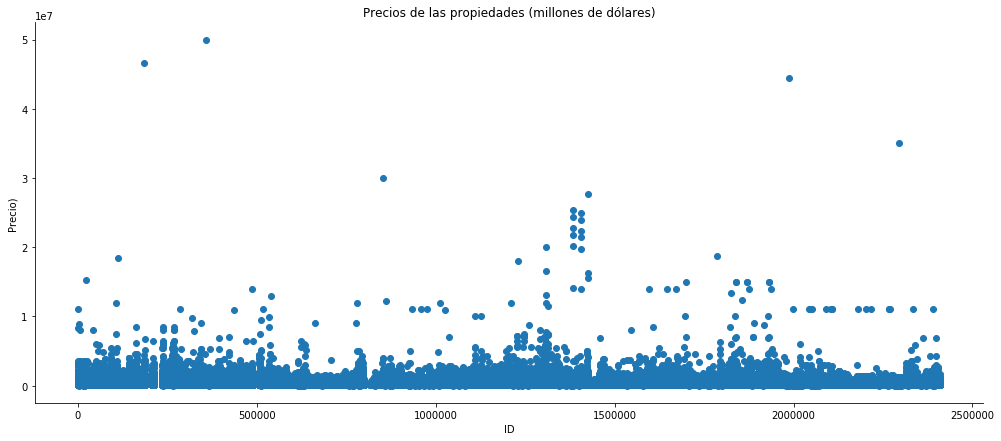

In [14]:
x = df.index
y = df['price_aprox_usd']


fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Precios de las propiedades (millones de dólares)')
ax.set_ylabel('Precio)')
ax.set_xlabel('ID')
ax.scatter(x,y)

La gran mayoría de precios se encuentran debajo del millón de dólares. Veamos la distribución del precio:

In [15]:
df['price_aprox_usd'].describe()

count    4.304400e+05
mean     2.068996e+05
std      3.597598e+05
min      2.001125e+04
25%      8.865248e+04
50%      1.315810e+05
75%      2.200000e+05
max      5.000000e+07
Name: price_aprox_usd, dtype: float64

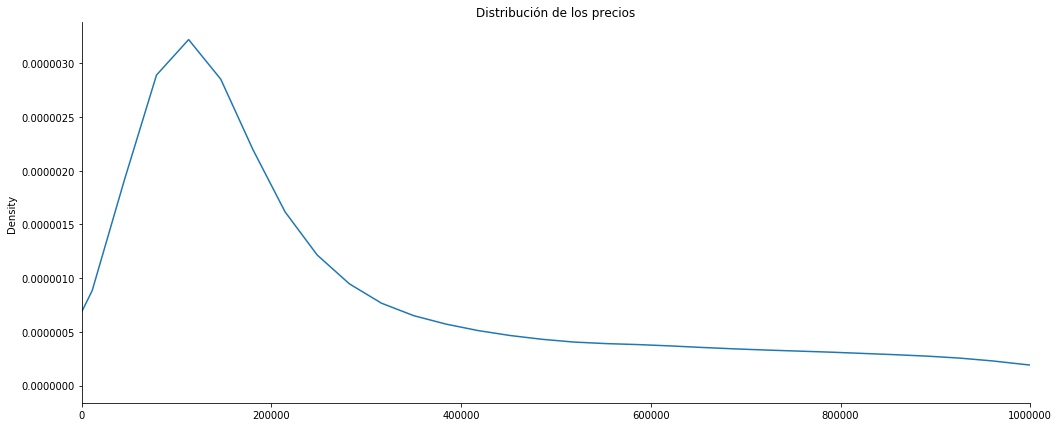

In [17]:
price = df[df['price_aprox_usd'] < 1000000].price

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Distribución de los precios')
ax.axis(xmin=0, xmax=1000000)
price.plot.kde(ax=ax)

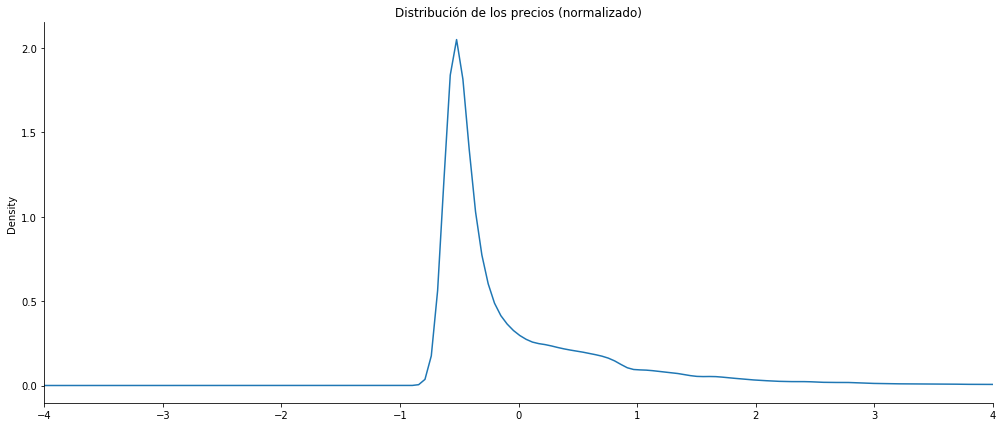

In [18]:
price = df[df['price_aprox_usd'] < 1000000].price
price = (price - price.mean()) / price.std()

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Distribución de los precios (normalizado)')
ax.axis(xmin=-4, xmax=4)
price.plot.kde(ax=ax)

La mayoría de los precios están levemente por debajo de la media: quiere decir que hay varias propiedades con valores extremadamente por encima que elevan el valor medio a lo que es

### Ordenamiento por Región
Las regiones están en la columna `place_with_parent_names` con el formato "Argentina|Capital Federal|Almagro|", guardo está informacion por separado

In [20]:
# Verifico que todos los rows tengan place definido
len(df.loc[df.place_with_parent_names.isnull() == True])

0

In [21]:
def split_region(x):
    state = x.split('|')[2]
    return state

def split_neighborhood(x):
    state = x.split('|')[3]
    return state

df['state'] = df.place_with_parent_names.apply(split_region)
df['barrio'] = df.place_with_parent_names.apply(split_neighborhood)

## Histograma de precios

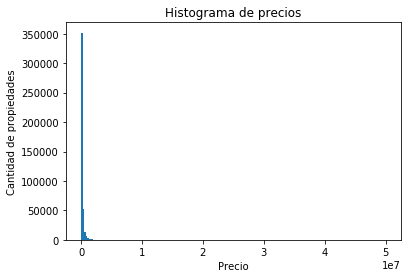

In [22]:
plt.hist(df.loc[df['price_aprox_usd'] > 0]['price_aprox_usd'], bins=200)
plt.xlabel("Precio")
plt.ylabel("Cantidad de propiedades")
plt.title("Histograma de precios")
plt.show()

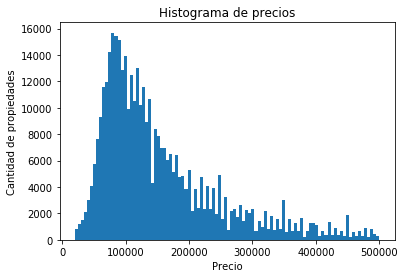

In [23]:
plt.hist(df.loc[(df['price_aprox_usd'] > 0) & (df['price_aprox_usd'] < 500000)]['price_aprox_usd'], bins=100)
plt.xlabel("Precio")
plt.ylabel("Cantidad de propiedades")
plt.title("Histograma de precios")
plt.figure(figsize=(17, 1))
plt.show()

## Tipos de propiedades

In [24]:
df['property_type'].value_counts()

apartment    289440
house        105353
PH            26864
store          8783
Name: property_type, dtype: int64

Acá nos damos cuentas los tipos de propiedades existentes. La gran mayoría son departamentos o casas residenciales.

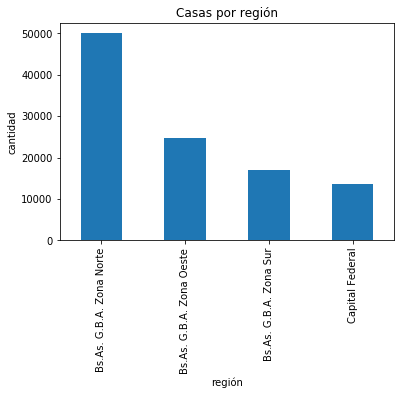

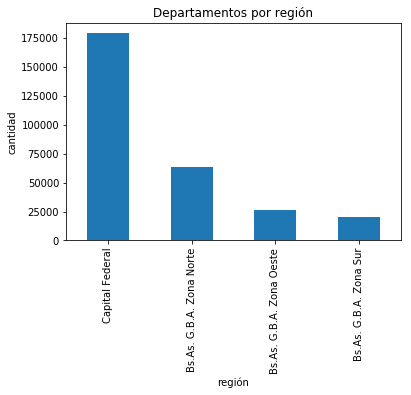

In [25]:
houses_by_state = df.loc[df['property_type'] == 'house']['state'].value_counts().plot(kind='bar')
houses_by_state.set_xlabel(u'región')
houses_by_state.set_ylabel('cantidad')
houses_by_state.set_title(u'Casas por región')
plt.show()
apartments_by_state = df.loc[df['property_type'] == 'apartment']['state'].value_counts().plot(kind='bar')
apartments_by_state.set_xlabel(u'región')
apartments_by_state.set_ylabel('cantidad')
apartments_by_state.set_title(u'Departamentos por región')
plt.show()

Como es de esperar, el grueso de las propiedades de tipo departamento están dentro de CABA, y las casas, afuera.

## Precios según tipo de propiedad

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f486f8f0bd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f486fd28990>]], dtype=object)

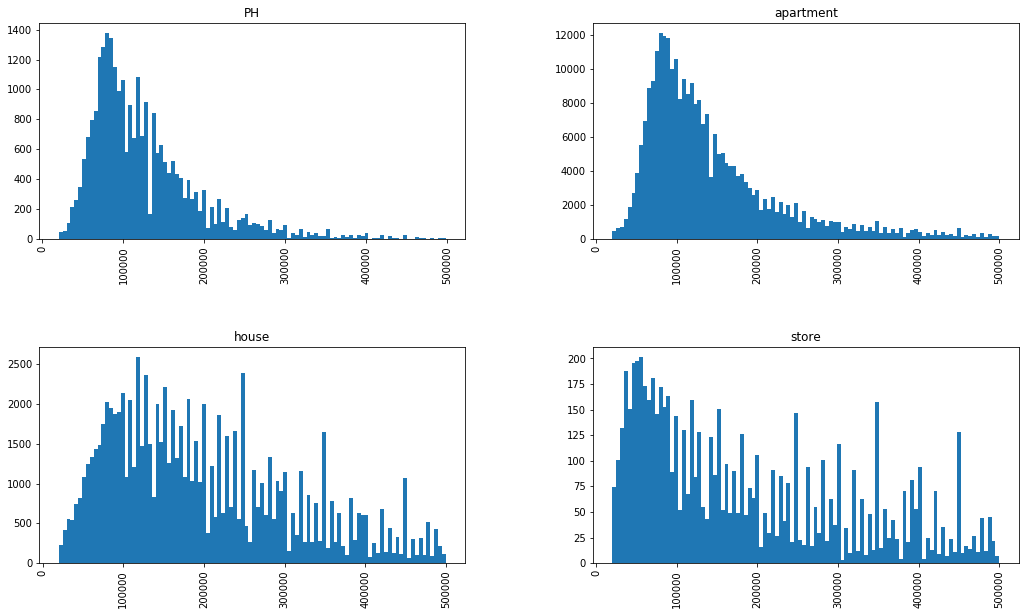

In [26]:
low_prices = df.loc[df['price_aprox_usd'] < 500000]
low_prices['price_aprox_usd'].hist(by=df['property_type'], bins=100, figsize=(17, 10))


Los precios de PH y departamentos se ajusta más a los de los precios en conjunto, mientras que las casas y negocios varían mucho más. Se espera que la media de estas últimas sean mayores a las primeras

In [27]:
df.groupby('property_type')['price_aprox_usd'].mean()

property_type
PH           134283.359548
apartment    179837.202638
house        283642.037526
store        400301.847175
Name: price_aprox_usd, dtype: float64

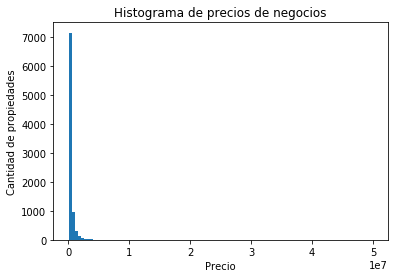

In [28]:
stores = df[df['property_type'] == 'store']
plt.hist(stores.loc[(stores['price_aprox_usd'] > 0)]['price_aprox_usd'], bins=100)
plt.xlabel("Precio")
plt.ylabel("Cantidad de propiedades")
plt.title("Histograma de precios de negocios")
plt.figure(figsize=(17, 1))
plt.show()

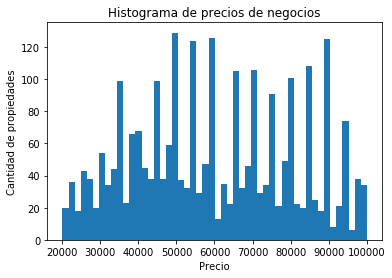

In [29]:
stores = df[df['property_type'] == 'store']
plt.hist(stores.loc[(stores['price_aprox_usd'] > 0) & (stores['price_aprox_usd'] < 100000)]['price_aprox_usd'], bins=50)
plt.xlabel("Precio")
plt.ylabel("Cantidad de propiedades")
plt.title("Histograma de precios de negocios")
plt.figure(figsize=(17, 1))
plt.show()

In [30]:
df.groupby('property_type')['price_aprox_usd'].std()

property_type
PH           251465.202489
apartment    302440.185443
house        420595.739062
store        930108.529016
Name: price_aprox_usd, dtype: float64

Se puede ver que el desvío (y la varianza) de las propiedades de tipo negocio es mucho más grande que las demás

## Barrios más caros

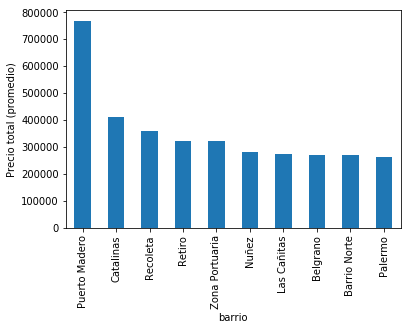

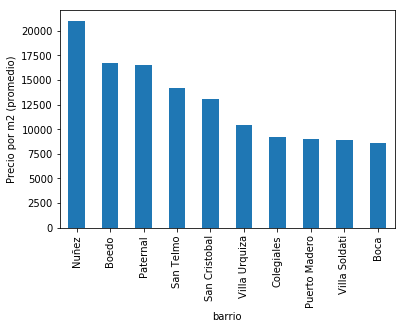

In [31]:
price = df.loc[df['state'] == 'Capital Federal'].loc[df['property_type'] == 'apartment'].groupby('barrio')['price_aprox_usd'].mean().nlargest(10).plot(kind='bar')
price.set_ylabel("Precio total (promedio)")
plt.show()
price_per_m2 = df.loc[df['state'] == 'Capital Federal'].loc[df['property_type'] == 'apartment'].groupby('barrio')['price_per_m2'].mean().nlargest(10).plot(kind='bar')
price_per_m2.set_ylabel("Precio por m2 (promedio)")
plt.show()

Se puede observar que algunos barrios coinciden en ambos casos. En particular el primer gráfico es consistente con [fuentes externas](http://www.lanacion.com.ar/2059858-los-barrios-mas-caros-de-la-ciudad-para-alquilar-un-departamento-de-dos-ambientes). Investigo 'Catalinas' y 'Zona Portuaria':

In [35]:
df.loc[df['barrio'] == 'Catalinas']

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title,state,barrio
495,Argentina,2015-09-12,USD,NaN,NaN,NaN,-34.603714,"-34.6037137392,-58.3815808896",-58.381581,sell,...,350000.0,3043.478261,store,NaN,115.0,NaN,0.0,Excelente Local situado en plena zona turística.,Capital Federal,Catalinas
71069,Argentina,2016-09-17,USD,NaN,NaN,NaN,-34.603684,"-34.6036844,-58.3815591",-58.381559,sell,...,74500.0,2328.125000,apartment,NaN,32.0,NaN,37.0,Departamento en venta ideal alquiler temporar...,Capital Federal,Catalinas
112625,Argentina,2016-12-04,USD,NaN,NaN,NaN,-34.627206,"-34.6272058442,-58.3614053355",-58.361405,sell,...,85000.0,1517.857143,apartment,3.0,56.0,NaN,56.0,Depto. de 3 ambientes con vista abierta.,Capital Federal,Catalinas
143065,Argentina,2017-02-13,USD,NaN,NaN,NaN,-34.600004,"-34.6000039032,-58.376624255",-58.376624,sell,...,550000.0,1929.824561,apartment,5.0,285.0,NaN,300.0,Excelente departamento antiguo en venta recicl...,Capital Federal,Catalinas
888995,NaN,2013-08-28,USD,NaN,NaN,NaN,-34.594029,"-34.594029,-58.379602",-58.379602,sell,...,650000.0,NaN,apartment,5.0,NaN,252.0,NaN,NaN,Capital Federal,Catalinas
925593,NaN,2013-12-11,USD,NaN,NaN,NaN,-34.594029,"-34.594029,-58.379602",-58.379602,sell,...,590000.0,NaN,apartment,5.0,NaN,252.0,NaN,NaN,Capital Federal,Catalinas
1018329,NaN,2013-12-02,USD,NaN,NaN,NaN,-34.594029,"-34.594029,-58.379602",-58.379602,sell,...,520000.0,NaN,apartment,5.0,NaN,270.0,NaN,NaN,Capital Federal,Catalinas
1292681,NaN,2015-06-26,USD,NaN,NaN,NaN,-34.594712,"-34.5947117175,-58.3741347454",-58.374135,sell,...,390000.0,NaN,store,NaN,NaN,115.0,NaN,Local a la calle en pleno centro porteño: Roja...,Capital Federal,Catalinas
1364770,NaN,2015-09-11,USD,NaN,NaN,NaN,-34.594949,"-34.5949487,-58.373328",-58.373328,sell,...,350000.0,NaN,store,NaN,NaN,115.0,NaN,Catalinas venta local a la calle en Dr.Ricardo...,Capital Federal,Catalinas
1385729,NaN,2015-09-12,USD,NaN,NaN,NaN,-29.537050,"-29.5370502,-62.2660294",-62.266029,sell,...,350000.0,NaN,store,NaN,NaN,0.0,NaN,Excelente Local situado en plena zona turística.,Capital Federal,Catalinas


In [36]:
df.loc[df['barrio'] == 'Zona Portuaria']

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title,state,barrio
183088,Argentina,2017-04-01,USD,NaN,NaN,NaN,-34.578833,"-34.5788332,-58.3731163",-58.373116,sell,...,320000.0,4266.666667,apartment,3.0,75.0,NaN,145.0,PUERTO MADERO,Capital Federal,Zona Portuaria


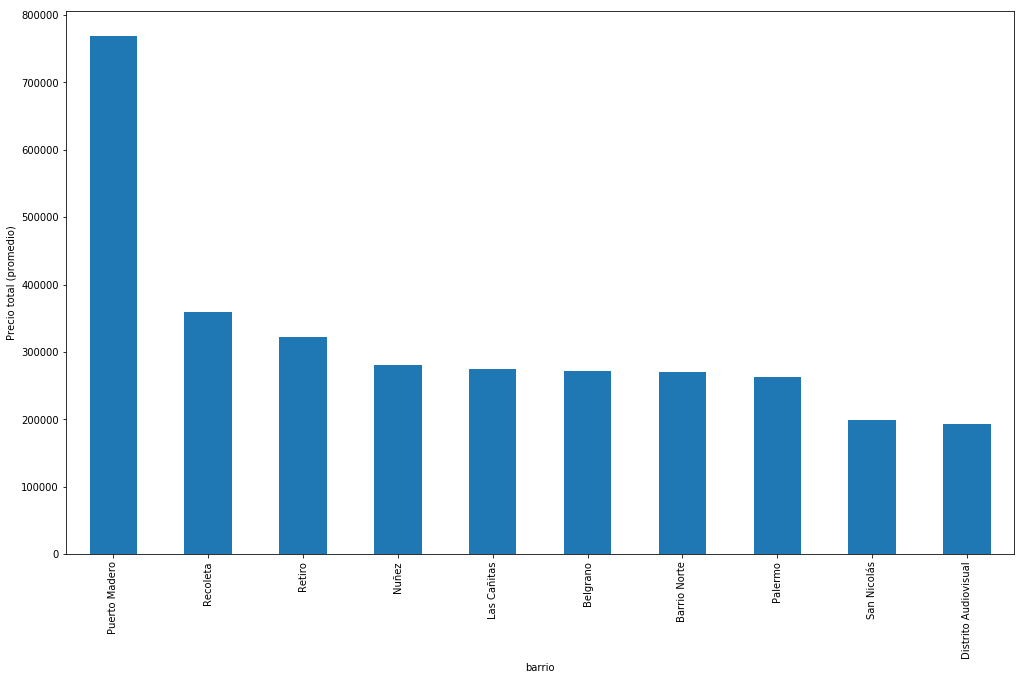

In [37]:
df_sin_outlier = df[df['barrio'] != 'Catalinas']
df_sin_outlier = df_sin_outlier[df_sin_outlier['barrio'] != 'Zona Portuaria']
price = df_sin_outlier.loc[df_sin_outlier['state'] == 'Capital Federal'].loc[df_sin_outlier['property_type'] == 'apartment'].groupby('barrio')['price_aprox_usd'].mean().nlargest(10).plot(kind='bar', figsize=(17, 10))
price.set_ylabel("Precio total (promedio)")
plt.show()

In [38]:
df_deptos_caros_capital = df.dropna(subset=['lat', 'lon'], how='any').loc[(df.property_type.str.contains('apartment'))&(df.place_name == 'Capital Federal')].sort_values('price_per_m2',ascending=False).head(100)

### Correlación tamaño - precio de las propiedades

In [39]:
df.surface_total_in_m2.isnull().value_counts()

True     321333
False    109107
Name: surface_total_in_m2, dtype: int64

In [40]:
df.surface_in_m2.isnull().value_counts()

True     234879
False    195561
Name: surface_in_m2, dtype: int64

In [41]:
def surface(x):
    if x.surface_total_in_m2:
        return x.surface_total_in_m2
    
    if x.surface_in_m2:
        return x.surface_in_m2
    
    if x.surface_covered_in_m2:
        return x.surface_covered_in_m2
    
    return 0

sf = df.apply(surface, axis=1)
sf.isnull().value_counts()

True     328436
False    102004
dtype: int64

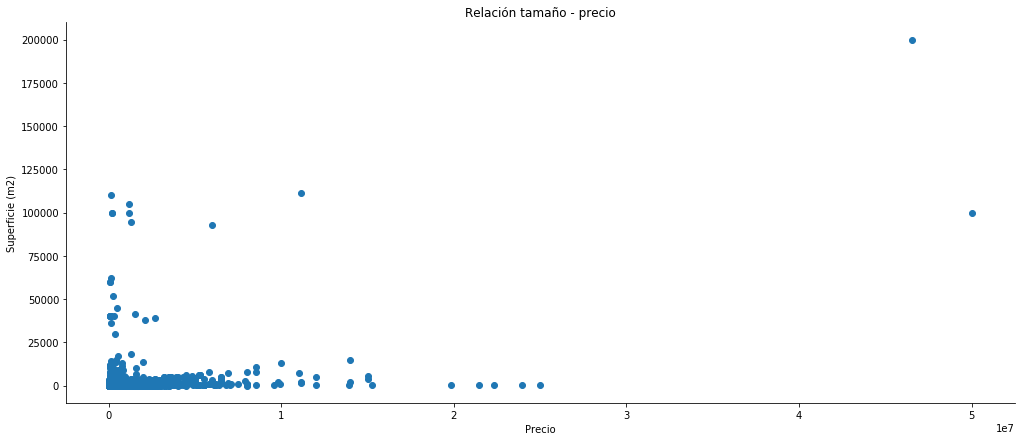

In [50]:
x = df.price_aprox_usd
y = df.surface_total_in_m2

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Relación tamaño - precio')
ax.set_ylabel(u'Superficie (m2)')
ax.set_xlabel('Precio')
ax.scatter(x,y)

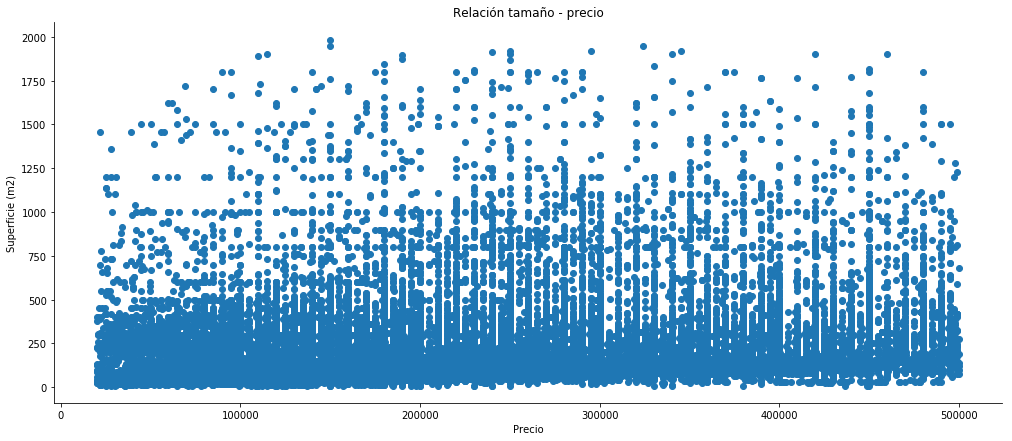

In [52]:
filtro = df.loc[(df.price_aprox_usd < 500000) & (df.price_aprox_usd > 20000)]
filtro = filtro.loc[(filtro.surface_total_in_m2 < 2000) & (filtro.surface_total_in_m2 > 0)]

x = filtro.price_aprox_usd
y = filtro.surface_total_in_m2

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Relación tamaño - precio')
ax.set_ylabel(u'Superficie (m2)')
ax.set_xlabel('Precio')
ax.scatter(x,y)

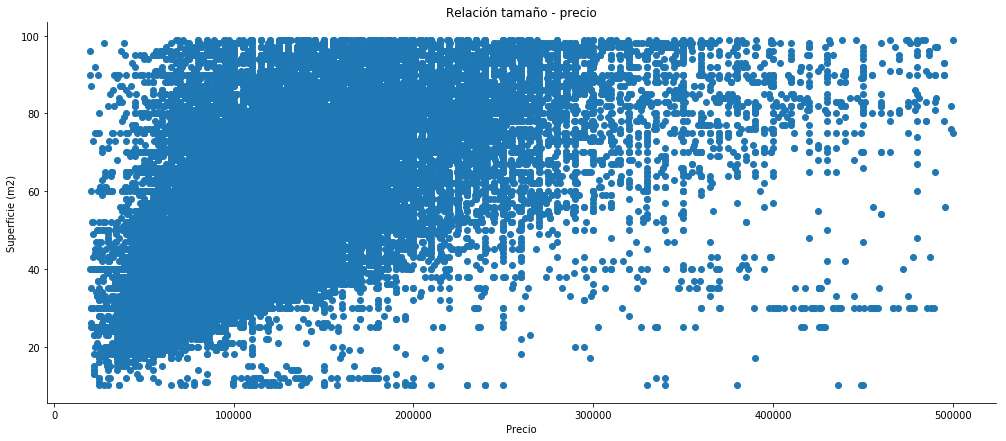

In [53]:
filtro = df.loc[(df.price_aprox_usd < 500000) & (df.price_aprox_usd > 20000)]
filtro = filtro.loc[(filtro.surface_total_in_m2 < 100) & (filtro.surface_total_in_m2 > 0)]

x = filtro.price_aprox_usd
y = filtro.surface_total_in_m2

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Relación tamaño - precio')
ax.set_ylabel(u'Superficie (m2)')
ax.set_xlabel('Precio')
ax.scatter(x,y)


En el orden de superficies bajas se puede notar una relación entre el precio y el tamaño de las mismas

## Precio según expensas

Primero hay que filtrar por los rows que tengan un valor de expensas definido. El tipo de la columna `expenses` fue definido como `object` debido a un problema de lectura de los datos (mal formateo). 

In [7]:
df['expenses'].isnull().value_counts()

True     2277825
False     131646
Name: expenses, dtype: int64

In [8]:
df[df['property_type'] == 'apartment']['expenses'].isnull().value_counts()

True     1265432
False     114012
Name: expenses, dtype: int64

In [43]:
def cast_to_float(x):
    if not x.expenses:
        return 0
    
    try:
        expenses = float(x.expenses)
        return expenses
    except:
        return 0

expenses = df.apply(cast_to_float, axis=1)
df['expenses'] = expenses

In [30]:
expenses_defined = df[df['expenses'] > 0]
expenses_defined.head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
0,Argentina,2015-07-01,USD,1500.0,NaN,3430234.0,-34.574594,"-34.5745944268,-58.4192548517",-58.419255,sell,...,71000.0,1133763.50,71000.0,2448.275862,apartment,1.0,29.0,NaN,29.0,Departamento en Palermo
1,Argentina,2015-07-01,USD,1.0,NaN,3427455.0,-34.610611,"-34.6106110157,-58.4795902886",-58.479590,sell,...,96000.0,1532976.00,96000.0,2285.714286,apartment,2.0,42.0,NaN,47.0,SAN BLAS 2700 6º- A ESTRENAR
2,Argentina,2015-07-01,USD,1.0,NaN,3427455.0,-34.610611,"-34.6106110157,-58.4795902886",-58.479590,sell,...,86000.0,1373291.00,86000.0,2047.619048,apartment,2.0,42.0,NaN,47.0,SAN BLAS 2700 4º- A ESTRENAR
10,Argentina,2015-07-02,USD,5000.0,NaN,3436077.0,-34.569881,"-34.5698809,-58.4417543",-58.441754,sell,...,420000.0,6706770.00,420000.0,3043.478261,apartment,NaN,138.0,NaN,153.0,departamento de 3 ambientes con dependencia de...
20,Argentina,2015-07-03,USD,875.0,3.0,3433918.0,-34.626397,"-34.6263967,-58.4684759",-58.468476,sell,...,92500.0,1477086.25,92500.0,1321.428571,apartment,3.0,70.0,NaN,70.0,DEPARTAMENTO EN VENTA


x = expenses_defined.price_aprox_usd
y = expenses_defined.expenses

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Relación precio - expensas')
ax.set_ylabel(u'Expensas')
ax.set_xlabel('Precio')
ax.scatter(x,y)

Veamos un gráfico más en detalle de los valores más bajos. Para eso primero hay que hacer una limpieza de los outliers

In [39]:
expenses_defined.sort_values(by='expenses').head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
13696,Argentina,2015-08-20,USD,1.0,NaN,3430234.0,-34.576239,"-34.5762386,-58.4199784",-58.419978,sell,...,185000.0,2954172.5,185000.0,5000.000000,apartment,1.0,37.0,NaN,40.0,Venta Monoambiente en Palermo Nuevo.
233810,Argentina,2017-05-24,USD,1.0,NaN,3433918.0,-34.629886,"-34.6298857,-58.4638709",-58.463871,sell,...,115000.0,1836377.5,115000.0,2500.000000,apartment,2.0,46.0,NaN,49.0,Dos Ambientes en Flores - venta de pozo
283067,Argentina,2017-08-01,NaN,1.0,NaN,3430234.0,NaN,NaN,NaN,sell,...,NaN,NaN,NaN,NaN,apartment,NaN,37.0,NaN,38.0,Departamento - Palermo
283068,Argentina,2017-08-01,NaN,1.0,NaN,3430234.0,NaN,NaN,NaN,sell,...,NaN,NaN,NaN,NaN,apartment,NaN,37.0,NaN,38.0,Departamento - Palermo
233809,Argentina,2017-05-24,USD,1.0,NaN,3433918.0,-34.629886,"-34.6298857,-58.4638709",-58.463871,sell,...,122000.0,1948157.0,122000.0,2392.156863,apartment,2.0,51.0,NaN,54.0,Dos Ambientes en Flores - venta en pozo


In [40]:
expenses_defined.sort_values(by='expenses', ascending=False).head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
2406118,NaN,2015-10-01,USD,2.003200e+19,NaN,3431273.0,-34.653324,"-34.6533241,-58.5334179",-58.533418,sell,...,50000.0,485035.0,50000.0,1315.789474,PH,NaN,38.0,NaN,38.0,PH EN VENTA
2387533,NaN,2015-10-01,USD,2.003200e+19,NaN,3431273.0,-34.653324,"-34.6533243,-58.5334177",-58.533418,sell,...,50000.0,475530.0,50000.0,NaN,PH,NaN,NaN,38.0,NaN,PH EN VENTA
263802,Argentina,2017-06-20,USD,1.000150e+07,NaN,3427407.0,-34.639515,"-34.6395149,-58.5071076",-58.507108,sell,...,140000.0,2470230.0,140000.0,3255.813953,apartment,2.0,43.0,NaN,46.0,DEPARTAMENTO EN VENTA
263803,Argentina,2017-06-20,USD,1.000150e+07,NaN,3427407.0,-34.639515,"-34.6395149,-58.5071076",-58.507108,sell,...,160000.0,2823120.0,160000.0,3720.930233,apartment,2.0,43.0,NaN,49.0,DEPARTAMENTO EN VENTA
247163,Argentina,2016-11-23,USD,8.659060e+05,NaN,3436077.0,NaN,NaN,NaN,sell,...,750000.0,13233375.0,750000.0,4335.260116,apartment,5.0,173.0,NaN,198.0,DEPARTAMENTO EN VENTA


In [45]:
expenses_defined = expenses_defined[expenses_defined.expenses < 100000]

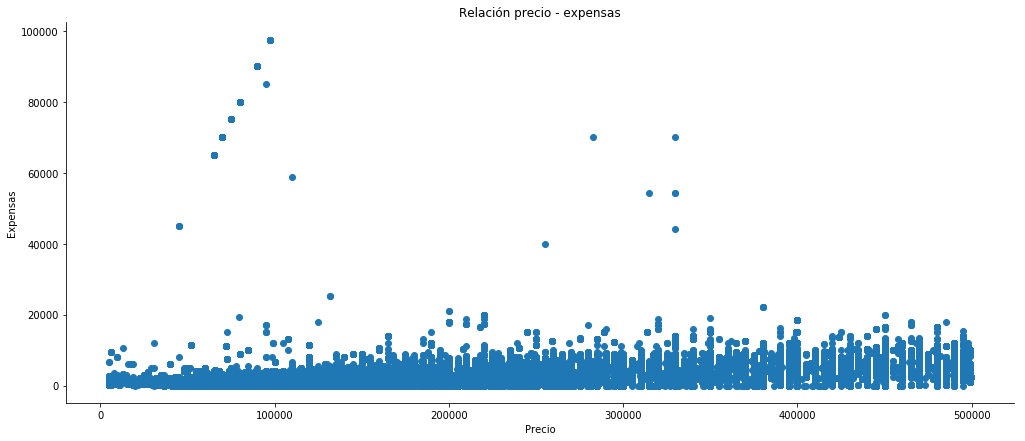

In [46]:
expenses_defined = expenses_defined[(expenses_defined.price_aprox_usd > 0) & (expenses_defined.price_aprox_usd < 500000)]
x = expenses_defined.price_aprox_usd
y = expenses_defined.expenses

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Relación precio - expensas')
ax.set_ylabel(u'Expensas')
ax.set_xlabel('Precio')
ax.scatter(x,y)

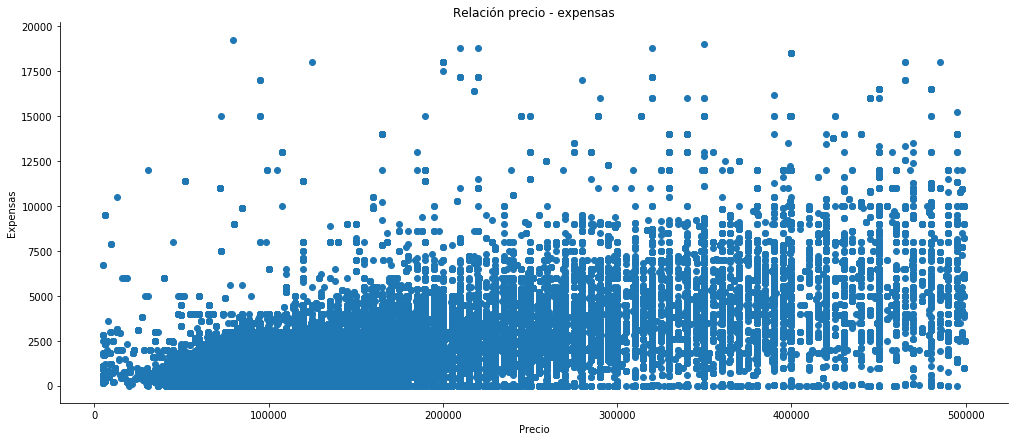

In [47]:
expenses_defined = expenses_defined[expenses_defined.expenses < 20000]
x = expenses_defined.price_aprox_usd
y = expenses_defined.expenses

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Relación precio - expensas')
ax.set_ylabel(u'Expensas')
ax.set_xlabel('Precio')
ax.scatter(x,y)

In [50]:
expenses_defined.corr()['price_aprox_usd']

KeyError: 'price_aprox_usd'

Se puede apreciar cierto crecimiento lineal del precio de una propiedad con sus expensas.

In [46]:
geometry = [Point(x,y) for x,y in zip(df_deptos_caros_capital['lon'], df_deptos_caros_capital['lat'])]

gs = GeoDataFrame(df_deptos_caros_capital, geometry=geometry)

In [47]:
gs.plot(marker='o', color='red', markersize=60, figsize=(4, 4))
mplleaflet.display()

In [48]:
df.loc[df['place_name'] == 'Capital Federal'].groupby('place_name')['price'].mean()

place_name
Capital Federal    419761.632313
Name: price, dtype: float64

## Precio según cantidad de habitaciones

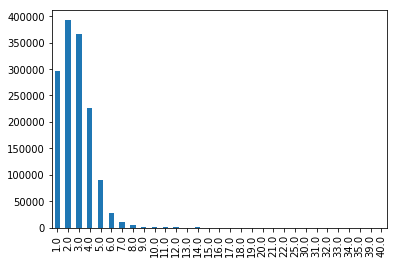

In [8]:
rooms = df.loc[df['rooms'] > 0]
rooms['rooms'].value_counts().sort_index().plot(kind='bar')

Viendo que el grueso de las propiedades tienen una cantidad de ambientes por debajo de los 10, considero las mayores como outliers.

In [20]:
rooms = rooms[rooms['rooms'] < 10]

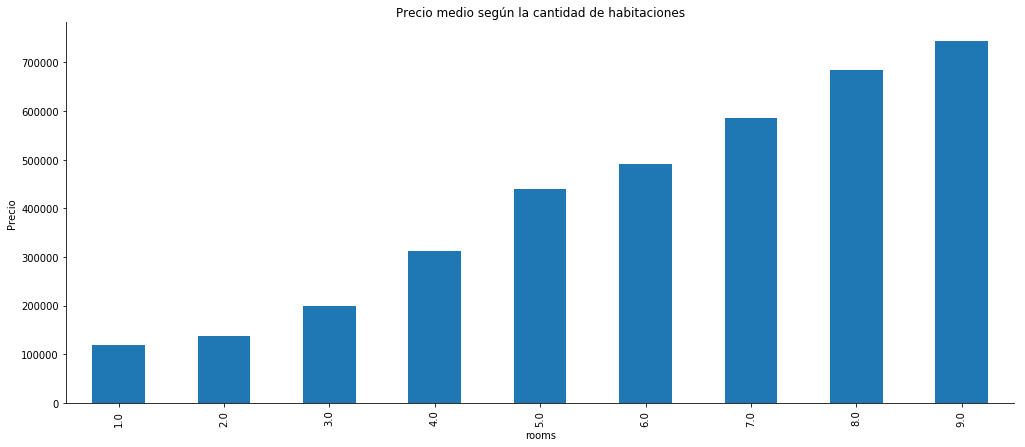

In [21]:
fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Precio medio según la cantidad de habitaciones')
ax.axis(xmin=0, xmax=1000000)
ax.set_ylabel('Precio')
ax.set_xlabel('Habitaciones')
rooms.groupby('rooms')['price_aprox_usd'].mean().plot(kind='bar')

In [22]:
rooms.corr().rooms

floor                        -0.011873
geonames_id                  -0.026886
lat                           0.010933
lon                          -0.013201
price                         0.069921
price_aprox_local_currency    0.352074
price_aprox_usd               0.339780
price_per_m2                 -0.060483
rooms                         1.000000
surface_covered_in_m2         0.005972
surface_in_m2                 0.132530
surface_total_in_m2           0.077174
Name: rooms, dtype: float64

# Precio según año

In [3]:
df['created_on'] = pd.to_datetime(df['created_on'], exact=False, infer_datetime_format=True, errors='coerce')
df['year'] = df['created_on'].map(lambda x:x.year)

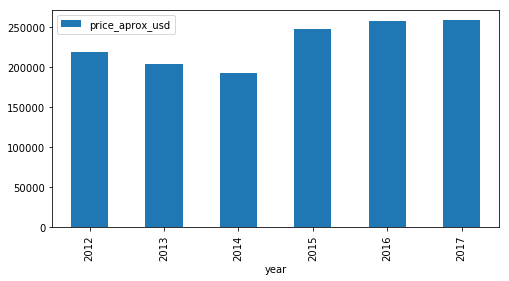

In [4]:
precio_por_anio_promedio = df.loc[:,['year', 'price_aprox_usd']].groupby('year').mean()
precio_por_anio_promedio.plot(kind='bar',rot=90,figsize=(8,4));

# Analisis de precios de casas según si tienen pileta, jardín o garage


In [6]:
df_analisis_pileta = df.dropna(subset=['title'], how='any')
df_analisis_pileta = df_analisis_pileta.loc[df_analisis_pileta['property_type'] == 'house']
df_analisis_pileta['extra'] = 'Simple'
df_analisis_pileta.loc[df_analisis_pileta['title'].str.contains("pileta"),['extra']] = 'Pileta'

df_analisis_jardin = df.dropna(subset=['title'], how='any')
df_analisis_jardin = df_analisis_jardin.loc[df_analisis_jardin['property_type'] == 'house']
df_analisis_jardin['extra'] = 'Simple'
df_analisis_jardin.loc[df_analisis_jardin['title'].str.contains("jardin"),['extra']] = 'Jardin'

df_analisis_garage = df.dropna(subset=['title'], how='any')
df_analisis_garage = df_analisis_garage.loc[df_analisis_garage['property_type'] == 'house']
df_analisis_garage['extra'] = 'Simple'
df_analisis_garage.loc[df_analisis_garage['title'].str.contains("garage"),['extra']] = 'Garage'

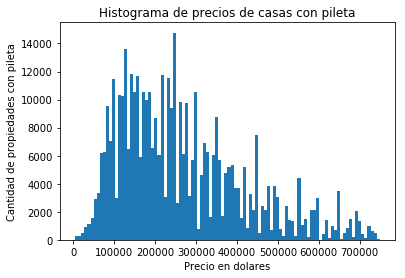

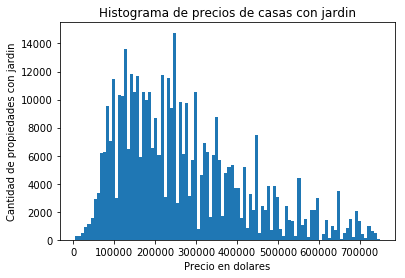

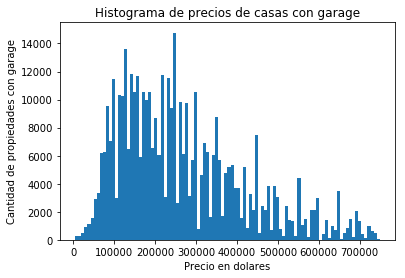

In [11]:
plt.hist(df_analisis_pileta.loc[(df_analisis_pileta['price_aprox_usd'] > 0) & (df_analisis_pileta['price_aprox_usd'] < 750000)]['price_aprox_usd'], bins=100)
plt.xlabel("Precio en dolares")
plt.ylabel("Cantidad de propiedades con pileta")
plt.title("Histograma de precios de casas con pileta")
plt.figure(figsize=(17, 1))
plt.show()

plt.hist(df_analisis_jardin.loc[(df_analisis_jardin['price_aprox_usd'] > 0) & (df_analisis_jardin['price_aprox_usd'] < 750000)]['price_aprox_usd'], bins=100)
plt.xlabel("Precio en dolares")
plt.ylabel("Cantidad de propiedades con jardin")
plt.title("Histograma de precios de casas con jardin")
plt.figure(figsize=(17, 1))
plt.show()

plt.hist(df_analisis_garage.loc[(df_analisis_garage['price_aprox_usd'] > 0) & (df_analisis_garage['price_aprox_usd'] < 750000)]['price_aprox_usd'], bins=100)
plt.xlabel("Precio en dolares")
plt.ylabel("Cantidad de propiedades con garage")
plt.title("Histograma de precios de casas con garage")
plt.figure(figsize=(17, 1))
plt.show()

# Relación precio vs distancia a subtes

In [13]:
dtypes = {
    'X': float,
    'Y': float
}
df_subtes = pd.read_csv('data/estaciones-de-subte.csv', dtype=dtypes, sep=',')

Me quedo con las 10.000 propiedades más caras de Capital Federal

In [58]:
df_prop_caras = df.dropna(subset=['lat', 'lon'], how='any').loc[df['place_name'] == 'Capital Federal',['lat', 'lon', 'price_aprox_usd', 'place_name', 'property_type']].sort_values('price_aprox_usd',ascending=False).head(10000)

In [27]:
def convert_rad(x):
    return pi/180*x

def dist_haversine(lat1, lon1, lat2, lon2):
    lat1 = convert_rad(lat1)
    lon1 = convert_rad(lon1)
    lat2 = convert_rad(lat2)
    lon2 = convert_rad(lon2)
    
    R = 6378.0
    dif_lat = lat2 - lat1
    dif_lon = lon2 - lon1
    dif_lat = abs(dif_lat)
    dif_lon = abs(dif_lon)

    return 2*R*asin(sqrt(sin(dif_lat/2)**2 + cos(lat1)*cos(lat2)*sin(dif_lon/2)**2))

Calculo la distancia de cada propiedad a la estación más cercana de subtes en kilometros

In [18]:
df_prop_caras['dist_subtes'] = 9999.9

for index, row in df_prop_caras.iterrows():
    dist = 9999.9
    for index_subtes, row_subtes in df_subtes.iterrows():
        d = dist_haversine(row['lat'], row['lon'], row_subtes['Y'], row_subtes['X'])
        
        if d < dist:
            dist = d
    
    df_prop_caras['dist_subtes'][index] = dist

C:\Users\FEDE\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [19]:
df_prop_caras.sort_values('dist_subtes',ascending=False).head(5)

,lat,lon,price_aprox_usd,place_name,property_type,dist_subtes
960027,34.521380,58.480048,720000.0,Capital Federal,house,9999.90000
968638,19.452192,-99.177132,520000.0,Capital Federal,apartment,7395.83557
968052,19.452192,-99.177132,715000.0,Capital Federal,apartment,7395.83557
968079,19.452192,-99.177132,540000.0,Capital Federal,apartment,7395.83557
972616,19.452192,-99.177132,430000.0,Capital Federal,apartment,7395.83557


Filtro las propiedades que estén a más de 4km de una estación cercana de subte

In [20]:
df_prop_caras = df_prop_caras[df_prop_caras['dist_subtes'] < 4.0]

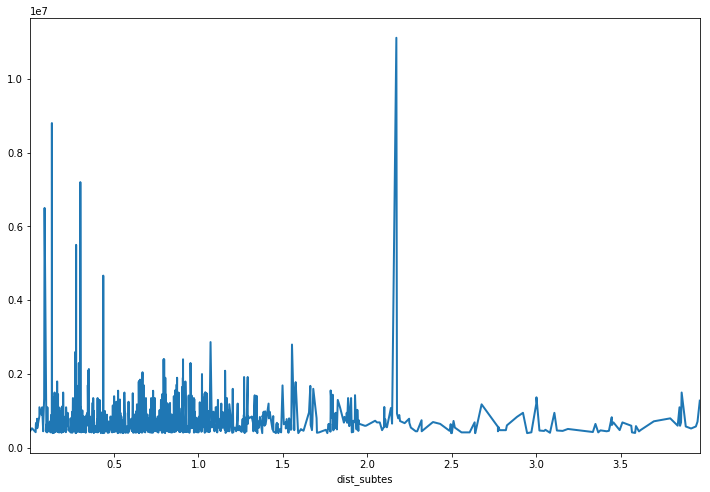

In [21]:
df_prop_caras.groupby('dist_subtes').mean().loc[:,'price_aprox_usd'].plot(linewidth=2,figsize=(12,8));

Veo la relación entre los precios de los departamentos y la distancia a la estación de subte más próxima

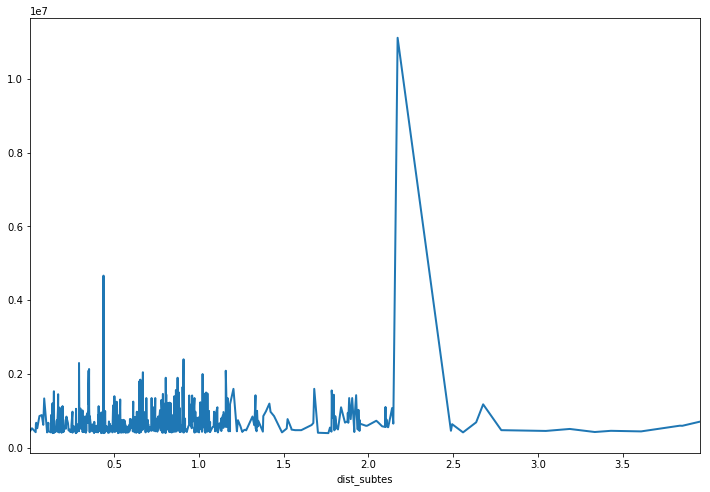

In [22]:
df_prop_caras.loc[df_prop_caras['property_type'] == 'apartment'].groupby('dist_subtes').mean().loc[:,'price_aprox_usd'].plot(linewidth=2,figsize=(12,8));

Veo la relación entre los precios de las casas y la distancia a la estación de subte más próxima

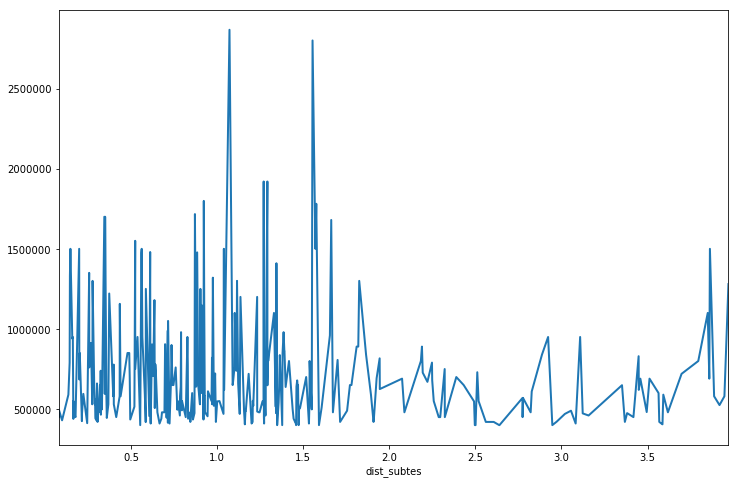

In [23]:
df_prop_caras.loc[df_prop_caras['property_type'] == 'house'].groupby('dist_subtes').mean().loc[:,'price_aprox_usd'].plot(linewidth=2,figsize=(12,8));

# Relación precio vs distancia a facultades públicas

In [24]:
dtypes = {
    'latitude': float,
    'longitude': float
}
df_facultades = pd.read_csv('data/facultades_publicas.csv', dtype=dtypes, sep=',')

In [25]:
df_prop_caras['dist_facus'] = 9999.9

for index, row in df_prop_caras.iterrows():
    dist = 9999.9
    for index_facus, row_facus in df_facultades.iterrows():
        d = dist_haversine(row['lat'], row['lon'], row_facus['latitude'], row_facus['longitude'])
        
        if d < dist:
            dist = d
    
    df_prop_caras['dist_facus'][index] = dist

C:\Users\FEDE\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [26]:
df_prop_caras.sort_values('dist_facus',ascending=False).head(5)

,lat,lon,price_aprox_usd,place_name,property_type,dist_subtes,dist_facus
240188,-34.636612,-58.499662,610000.0,Capital Federal,house,2.827282,4.689904
1181537,-34.646634,-58.496808,490000.0,Capital Federal,house,3.055278,4.628855
1038548,-34.636613,-58.484069,498000.0,Capital Federal,house,1.476103,4.523202
912539,-34.636613,-58.484069,550000.0,Capital Federal,house,1.476103,4.523202
889892,-34.636613,-58.484069,550000.0,Capital Federal,house,1.476103,4.523202


Filtro las propiedades que estén a más de 4km de una facultad pública

In [37]:
df_prop_caras = df_prop_caras[df_prop_caras['dist_facus'] < 4.0]

Veo la relación entre los precios de las casas y la distancia a la facultad más cercana

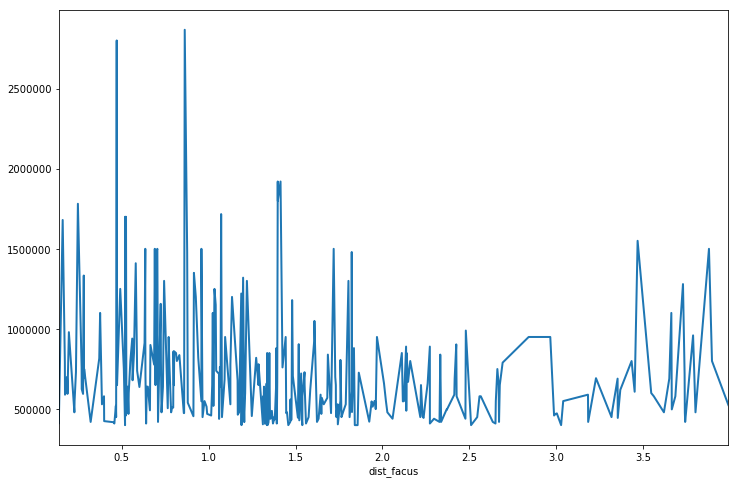

In [38]:
df_prop_caras.loc[df_prop_caras['property_type'] == 'house'].groupby('dist_facus').mean().loc[:,'price_aprox_usd'].plot(linewidth=2,figsize=(12,8));

Veo la relación entre los precios de los departamentos y la distancia a la facultad más cercana

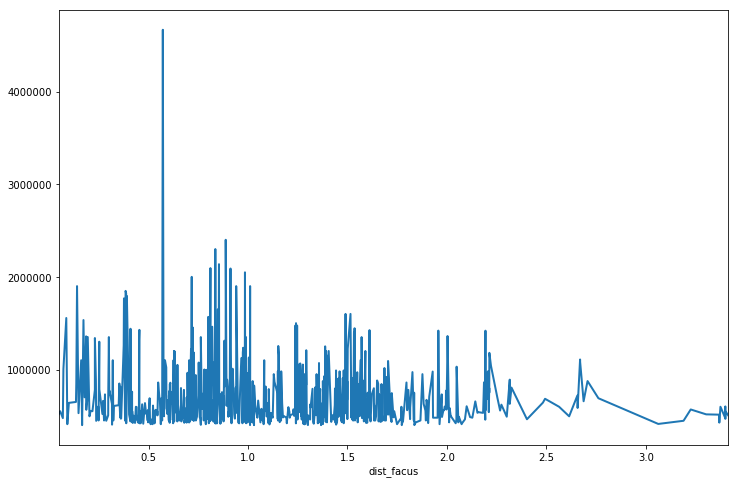

In [39]:
df_prop_caras.loc[df_prop_caras['property_type'] == 'apartment'].groupby('dist_facus').mean().loc[:,'price_aprox_usd'].plot(linewidth=2,figsize=(12,8));

# Relacion precio vs paradas del metrobus

In [31]:
dtypes = {
    'X': float,
    'Y': float
}
df_colectivos = pd.read_csv('data/estaciones-de-metrobus.csv', dtype=dtypes, sep=';',error_bad_lines=False)

In [32]:
geometry = [Point(x,y) for x,y in zip(df_colectivos['X'], df_colectivos['Y'])]

gs_colectivos = GeoDataFrame(df_colectivos, geometry=geometry)

In [34]:
gs_colectivos.plot()
mplleaflet.display()

In [36]:
df_prop_caras['dist_colectivos'] = 9999.9

for index, row in df_prop_caras.iterrows():
    dist = 9999.9
    for index_colectivos, row_colectivos in df_colectivos.iterrows():
        d = dist_haversine(row['lat'], row['lon'], row_colectivos['Y'], row_colectivos['X'])
        
        if d < dist:
            dist = d
    
    df_prop_caras['dist_colectivos'][index] = dist

C:\Users\FEDE\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [53]:
df_prop_caras.sort_values('dist_colectivos',ascending=False).head(5)

,lat,lon,price_aprox_usd,place_name,property_type,dist_colectivos
1007687,-34.450944,-58.626523,450000.0,Capital Federal,house,14.936635
1149289,-34.450944,-58.626523,450000.0,Capital Federal,house,14.936635
1026998,-34.450944,-58.626523,450000.0,Capital Federal,house,14.936635
1081451,-34.450944,-58.626523,450000.0,Capital Federal,house,14.936635
1114121,-34.450944,-58.626523,450000.0,Capital Federal,house,14.936635


In [54]:
df_prop_caras = df_prop_caras[df_prop_caras['dist_colectivos'] < 5.0]

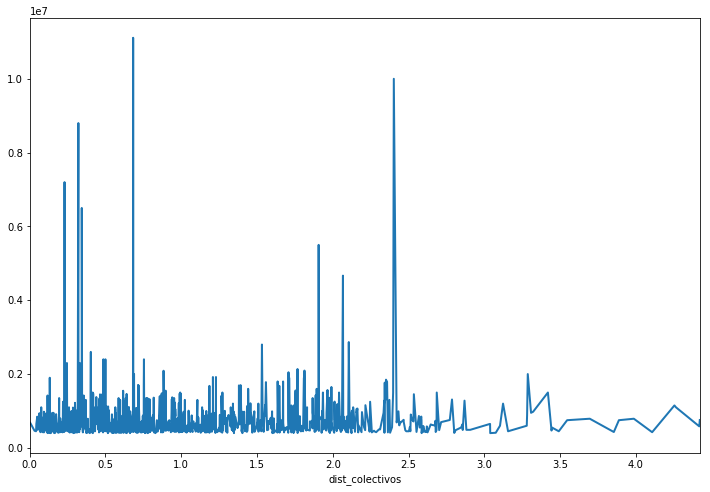

In [55]:
df_prop_caras.groupby('dist_colectivos').mean().loc[:,'price_aprox_usd'].plot(linewidth=2,figsize=(12,8));

Veo la relación entre los precios de las casas y la distancia a la parada más cercana

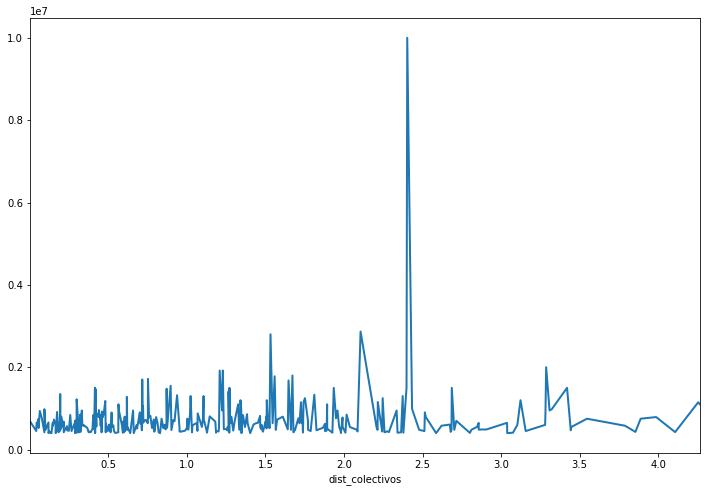

In [56]:
df_prop_caras.loc[df_prop_caras['property_type'] == 'house'].groupby('dist_colectivos').mean().loc[:,'price_aprox_usd'].plot(linewidth=2,figsize=(12,8));

Veo la relación entre los precios de los departamentos y la distancia a la parada más cercana

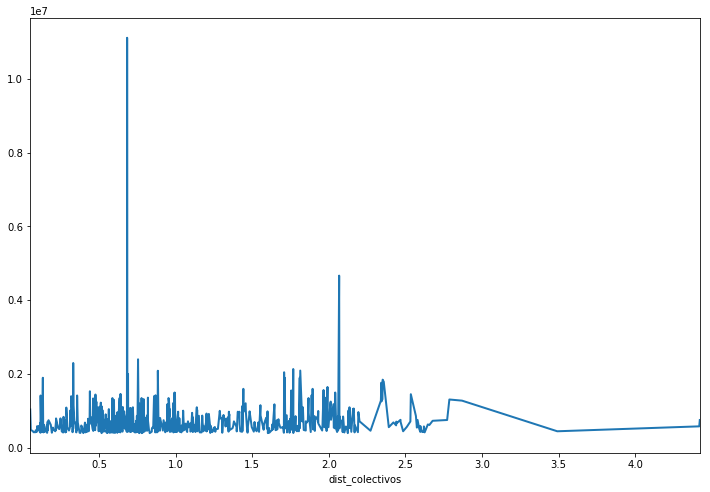

In [57]:
df_prop_caras.loc[df_prop_caras['property_type'] == 'apartment'].groupby('dist_colectivos').mean().loc[:,'price_aprox_usd'].plot(linewidth=2,figsize=(12,8));

# Relacion precio vs distancia a hospitales

In [61]:
dtypes = {
    'LNG': float,
    'LAT': float
}
df_hospitales = pd.read_csv('data/hospitales.csv', dtype=dtypes, sep=';',error_bad_lines=False)

In [62]:
geometry = [Point(x,y) for x,y in zip(df_hospitales['LNG'], df_hospitales['LAT'])]

gs_hospitales = GeoDataFrame(df_hospitales, geometry=geometry)

In [63]:
gs_hospitales.plot()
mplleaflet.display()

In [64]:
df_prop_caras['dist_hospitales'] = 9999.9

for index, row in df_prop_caras.iterrows():
    dist = 9999.9
    for index_h, row_h in df_hospitales.iterrows():
        d = dist_haversine(row['lat'], row['lon'], row_h['LAT'], row_h['LNG'])
        
        if d < dist:
            dist = d
    
    df_prop_caras['dist_hospitales'][index] = dist

C:\Users\FEDE\Anaconda3\envs\ipykernel_py2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [65]:
df_prop_caras.sort_values('dist_hospitales',ascending=False).head(5)

,lat,lon,price_aprox_usd,place_name,property_type,dist_hospitales
960027,34.521380,58.480048,720000.0,Capital Federal,house,9999.900000
968052,19.452192,-99.177132,715000.0,Capital Federal,apartment,7396.077233
972616,19.452192,-99.177132,430000.0,Capital Federal,apartment,7396.077233
968638,19.452192,-99.177132,520000.0,Capital Federal,apartment,7396.077233
968079,19.452192,-99.177132,540000.0,Capital Federal,apartment,7396.077233


In [69]:
df_prop_caras = df_prop_caras[df_prop_caras['dist_hospitales'] < 5.0]

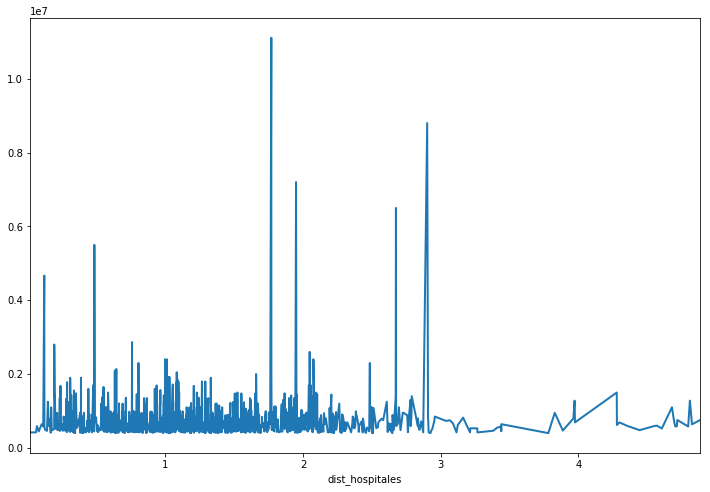

In [70]:
df_prop_caras.groupby('dist_hospitales').mean().loc[:,'price_aprox_usd'].plot(linewidth=2,figsize=(12,8));

Veo la relación entre los precios de las casas y la distancia al hospital más cercano

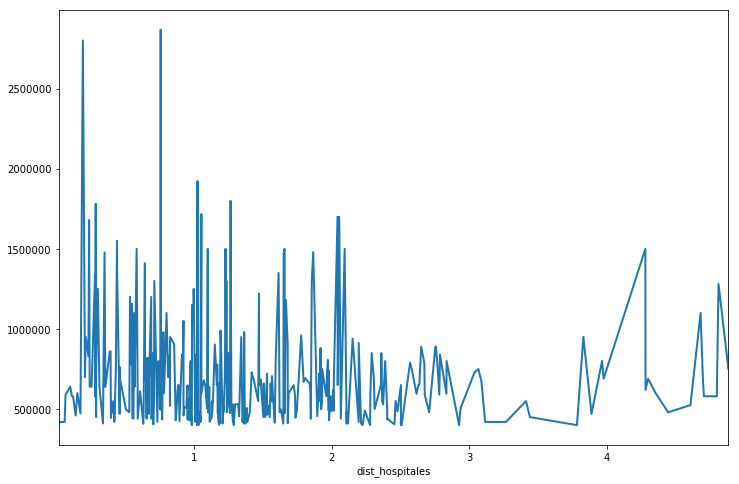

In [71]:
df_prop_caras.loc[df_prop_caras['property_type'] == 'house'].groupby('dist_hospitales').mean().loc[:,'price_aprox_usd'].plot(linewidth=2,figsize=(12,8));

Veo la relación entre los precios de los departamentos y la distancia al hospital más cercano

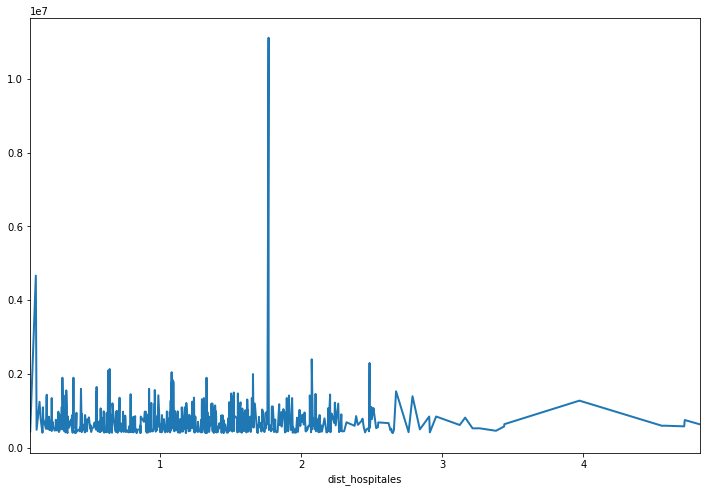

In [72]:
df_prop_caras.loc[df_prop_caras['property_type'] == 'apartment'].groupby('dist_hospitales').mean().loc[:,'price_aprox_usd'].plot(linewidth=2,figsize=(12,8));

# Incremento del precio entre los años 2015 - 2017

In [40]:
mask = (df['created_on'] >= '2015-08-08') & (df['created_on'] < '2016-08-08')
df_price_2015 = df.loc[mask]

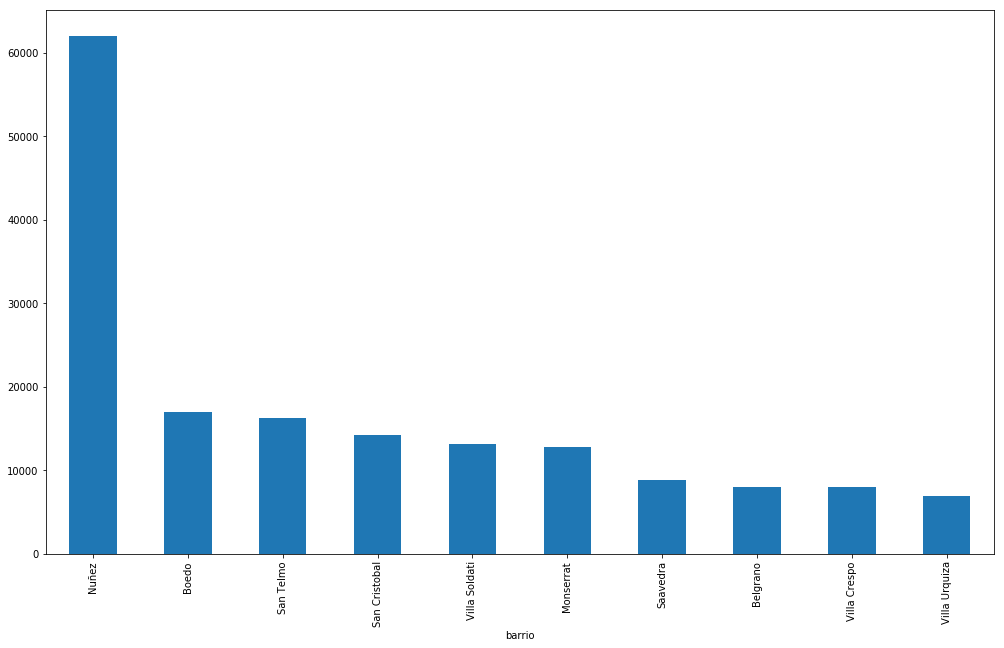

In [43]:
price_per_m2_15 = df_price_2015.loc[df_price_2015['state'] == 'Capital Federal'].loc[df_price_2015['property_type'] == 'apartment'].groupby('barrio')['price_per_m2'].mean().nlargest(10).plot(kind='bar', figsize=(17, 10))
price.set_ylabel("Precio promedio por metro cuadrado")
plt.show()

In [44]:
mask = (df['created_on'] >= '2016-08-08') & (df['created_on'] < '2017-08-08')
df_price_2016 = df.loc[mask]

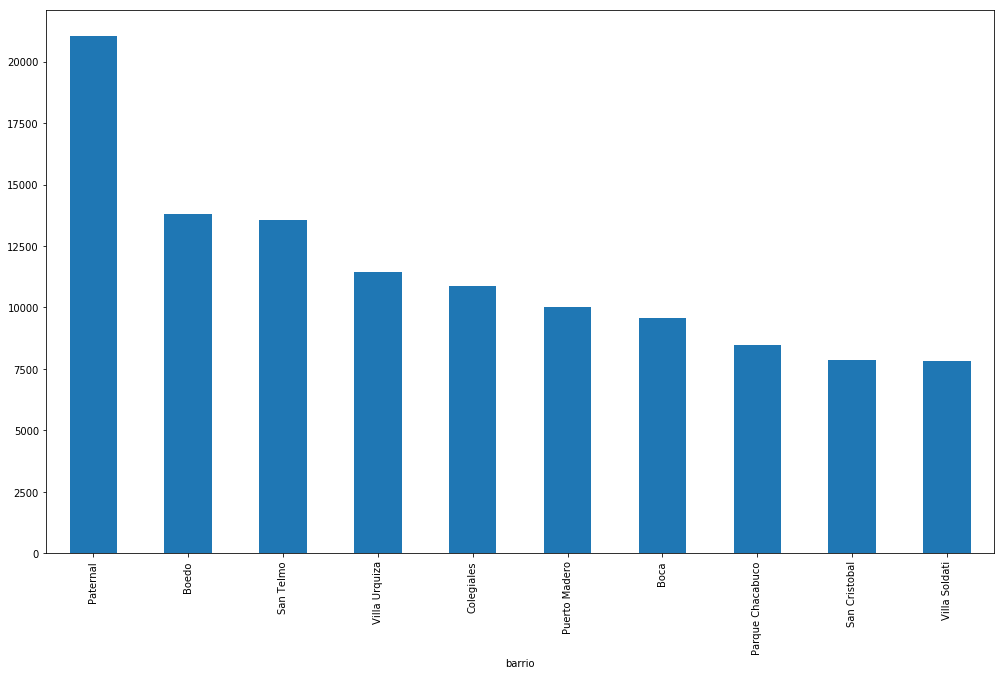

In [46]:
price_per_m2_16 = df_price_2016.loc[df_price_2016['state'] == 'Capital Federal'].loc[df_price_2016['property_type'] == 'apartment'].groupby('barrio')['price_per_m2'].mean().nlargest(10).plot(kind='bar', figsize=(17, 10))
price.set_ylabel("Precio promedio por metro cuadrado")
plt.show()

        Ahora calculo el incremento de valor del precio por metro cuadrado por barrio entre los años 2015 - 2017

In [58]:
df_price_16 = df_price_2016.loc[df_price_2016['state'] == 'Capital Federal'].loc[df_price_2016['property_type'] == 'apartment'].groupby('barrio')['price_per_m2'].mean().to_frame().reset_index() 

In [62]:
df_price_15 = df_price_2015.loc[df_price_2015['state'] == 'Capital Federal'].loc[df_price_2015['property_type'] == 'apartment'].groupby('barrio')['price_per_m2'].mean().to_frame().reset_index() 


In [80]:
incremento_precio = pd.merge(df_price_15,df_price_16, on = ['barrio'], how = 'outer')
print(incremento_precio.head())

      barrio  price_per_m2_x  price_per_m2_y
0                4134.220315     3733.120333
1     Abasto     5632.520323     2471.634009
2  Agronomía     2488.365919     2952.042964
3    Almagro     5649.488158     5208.368620
4  Balvanera     4715.777087     2442.473746


In [81]:
incremento_precio['incremento'] = 0
incremento_precio = incremento_precio.drop(incremento_precio.index[0])

print(incremento_precio.shape)

(61, 4)


In [82]:
for x in range(0, 60):
    incremento_precio.iloc[x,3] = (incremento_precio.iloc[x,2] / incremento_precio.iloc[x,1] ) * 100
        
print(incremento_precio.head(10))

          barrio  price_per_m2_x  price_per_m2_y  incremento
1         Abasto     5632.520323     2471.634009   43.881493
2      Agronomía     2488.365919     2952.042964  118.633797
3        Almagro     5649.488158     5208.368620   92.191867
4      Balvanera     4715.777087     2442.473746   51.793664
5       Barracas     6188.346290     5694.660578   92.022332
6   Barrio Norte     3182.860593     3793.563000  119.187218
7       Belgrano     8030.583275     6370.349790   79.326116
8           Boca     6762.088419     9581.953972  141.701104
9          Boedo    16927.440531    13784.097652   81.430489
10     Caballito     4229.607620     3926.950198   92.844314


In [83]:
incremento_precio.dropna(inplace=True)

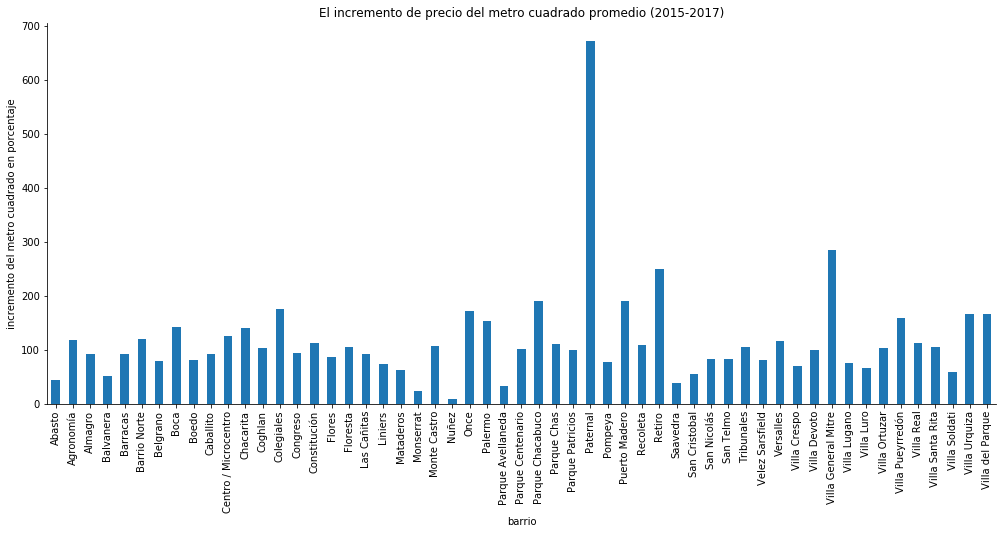

In [84]:
zonep_top_count = incremento_precio['incremento']
zonep_top_count.index = incremento_precio['barrio']

fig, ax = plt.subplots(figsize=(17, 7))
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('El incremento de precio del metro cuadrado promedio (2015-2017)')
plt.xlabel('Barrios')
plt.ylabel('incremento del metro cuadrado en porcentaje')


zonep_top_count.plot('bar');

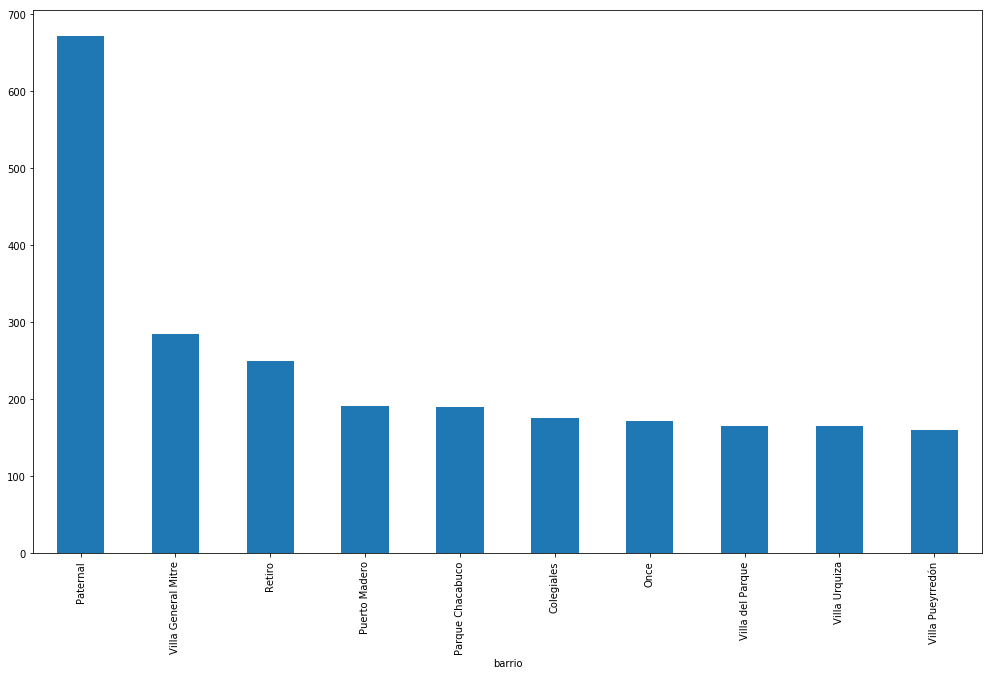

In [86]:
zonep_top_count.nlargest(10).plot(kind='bar', figsize=(17, 10));

# Incremento de inmuebles segun la cantidad de habitaciones

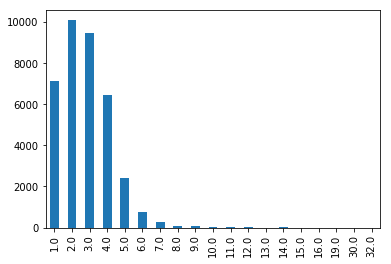

In [87]:
rooms = df_price_2015.loc[df_price_2015['rooms'] > 0]
rooms['rooms'].value_counts().sort_index().plot(kind='bar')

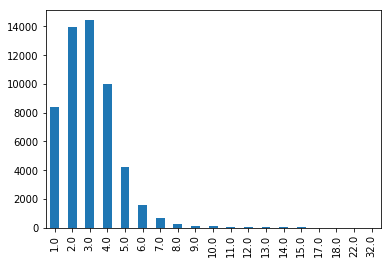

In [106]:

rooms = df_price_2016.loc[df_price_2016['rooms'] > 0]
rooms['rooms'].value_counts().sort_index().plot(kind='bar')

        Se observa un gran incremento en la oferta de inmuebles de 3 habitaciones